In [48]:
using LowRankModels, Plots, Random

LowRankModels.jl is a julia package for modeling and fitting generalized low rank models (GLRMs). GLRMs model a data array by a low rank matrix, and include many well known models in data analysis, such as principal components analysis (PCA), matrix completion, robust PCA, nonnegative matrix factorization, k-means, and many more.

LowRankModels.jl makes it easy to mix and match loss functions and regularizers to construct a model suitable for a particular data set. In particular, it supports

   * using different loss functions for different columns of the data array, which is useful when data types are heterogeneous (eg, real, boolean, and ordinal columns);
   * fitting the model to only some of the entries in the table, which is useful for data tables with many missing (unobserved) entries; and
   * adding offsets and scalings to the model without destroying sparsity, which is useful when the data is poorly scaled.


# Losses

You've already seen most of the loss functions available in LowRankModels.

For real valued $y$, try:
   * quadratic loss - `QuadLoss()`
   * $\ell_1$ loss - `L1Loss()`
   * quantile loss (for $\alpha$ quantile) - `QuantileLoss(α)`
 
For Boolean $y$, try
   * hinge loss - `HingeLoss()`
   * logistic loss - `LogisticLoss()`
   * weighted hinge loss - `WeightedHingeLoss()`

For nominal $y$, try
   * multinomial loss - `MultinomialLoss()`
   * one vs all loss - `OvALoss()`
       * (by default, it uses the logistic loss for the underlying binary classifier)

For ordinal $y$, try
   * ordinal hinge loss - `OrdinalHingeLoss()`
   * bigger vs smaller loss - `BvSLoss()`
       * (by default, it uses the logistic loss for the underlying binary classifier)

In [33]:
# example loss function
loss = QuadLoss()

QuadLoss(1.0, RealDomain())

In [34]:
loss = HingeLoss()

# evaluate method: 
#   first argument is prediction w^T x
#   first argument is desired output y (must be of correct type)
evaluate(loss, 1., 1)

0.0

In [38]:
# for ordinal and categorical losses, don't forget to specify number of levels
loss = BvSLoss(4) # ordinal loss on 4 levels 

BvSLoss(4, LogisticLoss(1.0, BoolDomain()), 1.0, OrdinalDomain(1, 4))

# Regularizer

We've also seen many of the regularizers available:

   * no regularization - `ZeroReg()`
   * quadratic regularization - `QuadReg()`
   * $\ell_1$ regularization - `OneReg()`
   * nonnegative constraint - `NonNegConstraint()`
   * constrained squared euclidean norm - `QuadConstraint()`
   * nonnegative constraint - `NonNegConstraint()` (eg, for nonnegative matrix factorization)
   * 1-sparse constraint - `OneSparseConstraint()` (eg, for orthogonal NNMF)
   * unit 1-sparse constraint - `UnitOneSparseConstraint()` (eg, for k-means)
   * simplex constraint - `SimplexConstraint()`
   * l1 regularization, combined with nonnegative constraint - `NonNegOneReg()`
   * fix features at values y0 - `FixedLatentFeaturesConstraint(y0)`

In [3]:
# regularizers
lambda = 1

nonneg = NonNegConstraint()
l1 = OneReg(lambda)
l2 = QuadReg(lambda)

QuadReg(1.0)

# Generalized Low Rank Models

GLRMs form a low rank model for tabular data A with m rows and n columns, which can be input as an array or any array-like object (for example, a data frame). It is fine if only some of the entries have been observed (i.e., the others are missing or NA); the GLRM will only be fit on the observed entries $\Omega$.

The desired model is specified by choosing a rank k for the model, an array of loss functions losses, and two regularizers, $r_x$ and $r_w$. The data is modeled as $X^TW$, where $X$ is a $k\times m$ matrix and $W$ is a $k\times n$ matrix. $X$ and $W$ are found by solving the optimization problem

$$\min \sum_{(i,j) \in \Omega} \ell_j\bigg((X^TW)[i,j], Y[i,j]\bigg) + \sum_i r_x(X[:,i]) + \sum_j r_y(W[:,j])$$

To form a GLRM, the user specifies

   * the data $Y$ (any AbstractArray, such as an array, a sparse matrix, or a data frame)
   * the array of loss functions $\ell$
   * the regularizers $r_x$ and $r_w$
   * the rank $k$
   * the observations $\Omega$


In [82]:
# example
Random.seed!(0)
Y = randn(10, 10)
Y = randn(10,3) * randn(3,10)
loss = QuadLoss()
nonneg = NonNegConstraint()
k = 5
Ω = [(rand(1:10), rand(1:10)) for iobs in 1:50] # observe 50 random entries, with replacement
glrm = GLRM(Y, loss, nonneg, nonneg, k, obs=Ω);

In [83]:
# example
Random.seed!(0)
Y = randn(10, 10)
Y = randn(10,3) * randn(3,10)
loss = QuadLoss()
reg = QuadReg(.01)
k = 5
Ω = [(rand(1:10), rand(1:10)) for iobs in 1:50] # observe 50 random entries, with replacement
glrm = GLRM(Y, loss, reg, reg, k, obs=Ω);

In [84]:
# To fit the model, call
X,W,ch = fit!(glrm);

Fitting GLRM
Iteration 10: objective value = 0.68709221847054
Iteration 20: objective value = 0.4768205548299535
Iteration 30: objective value = 0.43989884212830566
Iteration 40: objective value = 0.4077225266316519
Iteration 50: objective value = 0.38085641222723227
Iteration 60: objective value = 0.3607823513427642
Iteration 70: objective value = 0.3442264869360512


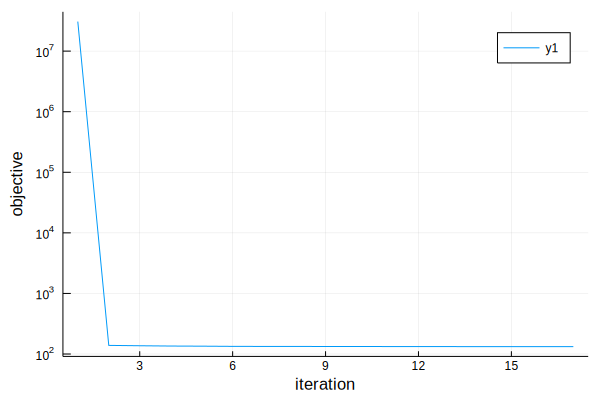

In [76]:
# did it converge? 
plot(ch.objective[2:end])
xlabel!("iteration")
ylabel!("objective")
yaxis!(:log)

This runs an alternating directions proximal gradient method on glrm to find the $X$ and $W$ minimizing the objective function.

In [77]:
X

5×10 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0        0.0  0.0  0.0   0.0   
 0.0  0.0  0.0  0.0  0.0  0.0064144  0.0  0.0  0.0  10.4898
 0.0  0.0  0.0  0.0  0.0  0.0        0.0  0.0  0.0   0.0   
 0.0  0.0  0.0  0.0  0.0  0.0        0.0  0.0  0.0   0.0   
 0.0  0.0  0.0  0.0  0.0  0.0        0.0  0.0  0.0   0.0   

In [78]:
W

5×10 Array{Float64,2}:
 0.0  0.0   57.2222  28.9911    44.2708   …  47.1575     0.0         0.0
 0.0  0.0   14.1247   1.87415    9.75311      0.0895796  6.21405e-5  0.0
 0.0  0.0   82.9888   0.856125  47.879       31.3586     0.0         0.0
 0.0  0.0   98.5249   0.842643  45.3493      32.6771     0.0         0.0
 0.0  0.0  116.849    0.197152  46.5014      25.2929     0.0         0.0

To allow further convergence, try running for more iterations. 
You can just call fit!(glrm) again, or increase the number of iterations.

In [71]:
fit!(glrm)

Fitting GLRM
Iteration 10: objective value = 0.2726121276096566


([-0.9508792893845344 -1.6980965243931438 … 0.31440328737673645 -0.6735887710461546; 0.9956195000653393 0.6024378603137155 … -0.09525417823606834 0.42874482320634083; … ; 0.5090139442832097 -0.21252354196196813 … 0.9810450160917564 -0.7759381159799644; 0.9790546577602636 0.03196807749322325 … -0.18668873457417343 -0.4333354199344537], [1.066631531156606 -0.5114088336221368 … 0.620431423337241 -0.8710936204433615; -0.49411926711834825 -0.24480870166712276 … 0.44789717880891533 -0.31149276323883734; … ; 0.7807981659267937 0.4574982666191339 … 0.7996228189491866 -0.7517615508097838; -0.6028021767108084 1.0496884852161958 … 0.8386336211004249 -0.10821655643146305], ConvergenceHistory("ProxGradGLRM", [0.5269102059150402, 0.271523606420757, 0.2716389260078322, 0.27182151013113504, 0.27184480782341863, 0.2719976779461943, 0.2720602432681906, 0.2722406264502965, 0.27230805288521315, 0.272515756325082, 0.2726121276096566, 0.27274929799055697], Float64[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

## Impute missing values

In [79]:
# predicted values for all entries
impute(glrm)

10×10 Array{Number,2}:
 0.0  0.0    0.0         0.0        …  0.0          0.0          0.0
 0.0  0.0    0.0         0.0           0.0          0.0          0.0
 0.0  0.0    0.0         0.0           0.0          0.0          0.0
 0.0  0.0    0.0         0.0           0.0          0.0          0.0
 0.0  0.0    0.0         0.0           0.0          0.0          0.0
 0.0  0.0    0.0906014   0.0120215  …  0.000574599  3.98594e-7   0.0
 0.0  0.0    0.0         0.0           0.0          0.0          0.0
 0.0  0.0    0.0         0.0           0.0          0.0          0.0
 0.0  0.0    0.0         0.0           0.0          0.0          0.0
 0.0  0.0  148.165      19.6595        0.939673     0.000651842  0.0

In [80]:
# predicted values for missing entries; observed values for observed entries 
impute_missing(glrm)

10×10 Array{Number,2}:
 -1.18952    2.02585      3.29352    …   0.0        0.0           0.67119
 -2.71644    0.0          3.25741        0.0        0.0           0.0    
  0.0        1.88773      0.0            0.0        1.31051       0.0    
  0.0       -0.956426     0.0            0.739071   0.0           0.0    
  0.651365  -0.0445085   -0.496102       0.792168   0.0          -1.6193 
  3.0512     0.0          0.0906014  …  -3.22293    0.107174      0.0    
  0.0        2.1272       1.40155        0.0        2.72786       0.0    
  0.22059    1.10867      0.487074      -1.5982    -0.386102      2.60075
  0.0        0.0          0.0            0.0        0.0          -1.10191
 -1.91504    0.0        148.165          0.940182   0.000651842   0.0    

# Initialization

You'll also often improve convergence, or even converge to a better solution, with good initialization:

Fitting GLRM
Iteration 10: objective value = 0.9564031740585974
Iteration 20: objective value = 0.775583015097639
Iteration 30: objective value = 0.6417889717990704
Iteration 40: objective value = 0.552691912763894
Iteration 50: objective value = 0.48706747973121706
Iteration 60: objective value = 0.4367865028514586
Iteration 70: objective value = 0.4008756835356213
Iteration 80: objective value = 0.38075148058832464
Iteration 90: objective value = 0.36550561346591504
Iteration 100: objective value = 0.34727967201268367


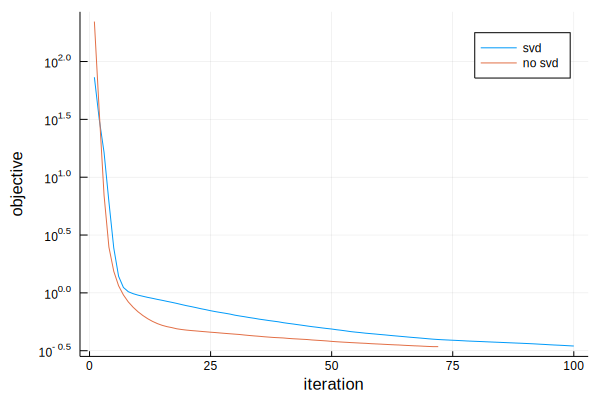

In [85]:
init_svd!(glrm)
X,W,ch_svd = fit!(glrm)
plot(ch_svd.objective[2:end], label="svd")
plot!(ch.objective[2:end], label="no svd")
xlabel!("iteration")
ylabel!("objective")
yaxis!(:log)

# Treating different columns differently
The losses argument can also be an array of loss functions, with one for each column (in order). For example, for a data set with 4 columns, you could use:

In [16]:
losses = Loss[QuadLoss(), LogisticLoss(), HingeLoss(), BvSLoss(4)]

4-element Array{Loss,1}:
 QuadLoss(1.0, RealDomain())                                          
 LogisticLoss(1.0, BoolDomain())                                      
 WeightedHingeLoss(1.0, BoolDomain(), 1.0)                            
 BvSLoss(4, LogisticLoss(1.0, BoolDomain()), 1.0, OrdinalDomain(1, 4))

Similiarly, the $r_w$ argument can be an array of regularizers, with one for each column (in order). For example, for a data set with 3 columns, you could use:

In [27]:
rw = Regularizer[QuadReg(1), QuadReg(10), OneReg()]

3-element Array{Regularizer,1}:
 QuadReg(1.0) 
 QuadReg(10.0)
 OneReg(1.0)  

# Example: PCA

In [28]:
# minimize ||Y - XW||^2
function fit_pca(m,n,k)
	# matrix to encode
	Y = randn(m,k)*randn(k,n)
	loss = QuadLoss()
	r = ZeroReg()
	glrm = GLRM(Y,loss,r,r,k)
	X,W,ch = fit!(glrm)
	println("Convergence history:",ch.objective)
	return Y,X,W,ch
end

fit_pca (generic function with 1 method)